# NDS Nonlinear Mode-Coupling Analysis with Spectral Decomposition and Baseline Comparison

This notebook demonstrates the **Nonlinear Diffusion Signatures (NDS)** experiment on graph pairs from the BREC benchmark domain. The experiment has four parts:

- **Part A**: Full init × nonlinearity × T ablation measuring whether nonlinear NDS distinguishes more graph pairs than linear NDS
- **Part B**: Spectral decomposition of NDS outputs into Laplacian eigenbasis to quantify cross-frequency coupling energy
- **Part C**: Head-to-head comparison of NDS against RWSE, LapPE, and substructure counting baselines
- **Part D**: Per-init feature variation analysis across graph types

The experiment uses synthetic non-vertex-transitive (non-VT) cubic graph pairs (Frucht vs Tietze, random cubic graphs) to test whether nonlinear mode coupling improves graph distinguishability beyond what linear diffusion achieves.

**Verdict**: PARTIAL_SUPPORT — coupling energy increases with nonlinearity (betweenness+tanh Δ=0.129) but does NOT improve distinguishing power.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# loguru — NOT on Colab, always install
_pip('loguru==0.7.3')

# numpy, scipy, matplotlib — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import time
import sys
from collections import defaultdict

import numpy as np
from scipy import linalg as sp_linalg
import matplotlib.pyplot as plt

from loguru import logger

# Logging setup
logger.remove()
logger.add(sys.stdout, level="INFO", format="{time:HH:mm:ss}|{level:<7}|{message}")

1

## Load Reference Data

Load pre-computed reference results from the full experiment run for comparison.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-7ff1bb-nonlinear-diffusion-signatures-breaking-/main/experiment_iter4_nds_nonlinear_m/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded reference data: {data['metadata']['method_name']}")
print(f"Total pairs in full experiment: {data['metadata']['total_pairs']}")
print(f"VT pairs: {data['metadata']['vt_pairs']}, Non-VT pairs: {data['metadata']['non_vt_pairs']}")
print(f"Verdict: {data['metadata']['verdict']}")
print(f"Datasets: {[ds['dataset'] for ds in data['datasets']]}")

Loaded reference data: NDS_ModeCoupling_Spectral_Baseline_Comparison
Total pairs in full experiment: 15
VT pairs: 9, Non-VT pairs: 6
Verdict: PARTIAL_SUPPORT_COUPLING_BUT_NO_DISTINGUISH_GAIN
Datasets: ['part_a_nds_ablation', 'part_b_spectral_coupling', 'part_c_baseline_comparison', 'part_d_feature_analysis']


## Configuration

All tunable parameters for the experiment. Start with minimum values for fast iteration.

In [5]:
# --- Tunable parameters ---
# Nonlinearities to test in Part A ablation
# Original: ["linear", "relu", "tanh", "leaky_relu", "abs", "square", "sin"]
NONLINEARITIES = ["linear", "relu", "tanh", "leaky_relu", "abs", "square", "sin"]

# Diffusion time steps to test in Part A
# Original: [1, 2, 5, 10, 15, 20]
T_VALUES = [1, 2, 5, 10, 15, 20]

# Scalar init functions to use (keys into SCALAR_INITS dict)
# Original: all 7 — ["degree", "clustering_coeff", "betweenness", "pagerank",
#                     "eigvec_centrality", "subgraph_centrality", "heat_kernel_diag"]
SCALAR_INIT_NAMES = ["degree", "clustering_coeff", "betweenness", "pagerank",
                     "eigvec_centrality", "subgraph_centrality", "heat_kernel_diag"]

# Part B: Spectral decomposition settings
# Original: T_FIXED=10, INITS=["degree","clustering_coeff","betweenness"],
#           NONLINS=["linear","relu","tanh","abs","square","sin"]
T_FIXED = 10
INITS_FOR_SPECTRAL = ["degree", "clustering_coeff", "betweenness"]
NONLINS_FOR_SPECTRAL = ["linear", "relu", "tanh", "abs", "square", "sin"]

# Part C: Baseline comparison settings
RWSE_K_MAX = 20        # Original: 20
LAPPE_K = 20           # Original: 20
PAGERANK_MAX_ITER = 100  # Original: 100
PAGERANK_ALPHA = 0.85   # Original: 0.85

# Synthetic pair generation settings
# Original: [(20,42,137), (20,271,503), (30,42,137), (30,271,503), (40,42,137)]
SYNTH_CONFIGS = [
    ("synth_cubic_20_s1s2", 20, 42, 137),
    ("synth_cubic_20_s3s4", 20, 271, 503),
    ("synth_cubic_30_s1s2", 30, 42, 137),
    ("synth_cubic_30_s3s4", 30, 271, 503),
    ("synth_cubic_40_s1s2", 40, 42, 137),
]

print(f"Config: {len(NONLINEARITIES)} nonlinearities × {len(T_VALUES)} T values × {len(SCALAR_INIT_NAMES)} inits")
print(f"Synthetic pairs: 1 (Frucht vs Tietze) + {len(SYNTH_CONFIGS)} random cubic = {1 + len(SYNTH_CONFIGS)} total")

Config: 7 nonlinearities × 6 T values × 7 inits
Synthetic pairs: 1 (Frucht vs Tietze) + 5 random cubic = 6 total


## Graph Utility Functions

Core functions for building graph representations, computing normalized adjacency matrices, and Laplacian eigendecomposition.

In [6]:
def compute_normalized_adjacency(A: np.ndarray) -> np.ndarray:
    """Compute D^{-1/2} A D^{-1/2} (symmetric normalized adjacency)."""
    degrees = A.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(degrees, 1e-15)))
    return D_inv_sqrt @ A @ D_inv_sqrt


def compute_laplacian_eigen(A: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Compute Laplacian eigenvalues and eigenvectors: L = D - A."""
    degrees = A.sum(axis=1)
    L = np.diag(degrees) - A
    eigvals, eigvecs = np.linalg.eigh(L)
    return eigvals, eigvecs


def build_graph_from_adjacency(A: np.ndarray, name: str = "unknown") -> dict:
    """Build a graph data structure from an adjacency matrix."""
    n = A.shape[0]
    m = int(A.sum()) // 2
    degree = A.sum(axis=1)
    A_norm = compute_normalized_adjacency(A)
    eigvals, eigvecs = compute_laplacian_eigen(A)
    return {
        "A": A,
        "A_norm": A_norm,
        "eigvals": eigvals,
        "eigvecs": eigvecs,
        "degree": degree,
        "n": n,
        "m": m,
        "name": name,
    }

logger.info("Graph utility functions defined")

23:44:12|INFO   |Graph utility functions defined


## Synthetic Graph Generation

Generate non-vertex-transitive cubic graph pairs: Frucht vs Tietze (12 nodes each) and random cubic graphs on various sizes.

In [7]:
def _frucht_graph() -> np.ndarray:
    """Frucht graph: 12 nodes, 3-regular, trivial automorphism group (non-VT)."""
    edges = [
        (0,1),(0,6),(0,11),
        (1,2),(1,7),
        (2,3),(2,8),
        (3,4),(3,9),
        (4,5),(4,10),
        (5,6),(5,11),
        (6,7),
        (7,8),
        (8,9),
        (9,10),
        (10,11),
    ]
    n = 12
    A = np.zeros((n, n), dtype=np.float64)
    for i, j in edges:
        A[i, j] = 1.0
        A[j, i] = 1.0
    return A


def _tietze_graph() -> np.ndarray:
    """Tietze graph: 12 nodes, 3-regular, non-vertex-transitive."""
    edges = [
        (0,1),(0,4),(0,9),
        (1,2),(1,6),
        (2,3),(2,11),
        (3,4),(3,7),
        (4,5),
        (5,6),(5,10),
        (6,7),
        (7,8),
        (8,9),(8,11),
        (9,10),
        (10,11),
    ]
    n = 12
    A = np.zeros((n, n), dtype=np.float64)
    for i, j in edges:
        A[i, j] = 1.0
        A[j, i] = 1.0
    return A


def _random_cubic_graph(n: int, seed: int) -> np.ndarray:
    """Generate a random 3-regular (cubic) graph on n nodes using a pairing model."""
    rng = np.random.RandomState(seed)
    for attempt in range(50):
        points = list(range(n)) * 3
        rng.shuffle(points)
        A = np.zeros((n, n), dtype=np.float64)
        valid = True
        for k in range(0, len(points), 2):
            u, v = points[k], points[k + 1]
            if u == v or A[u, v] > 0:
                valid = False
                break
            A[u, v] = 1.0
            A[v, u] = 1.0
        if valid and np.all(A.sum(axis=1) == 3):
            return A
        rng = np.random.RandomState(seed * 100 + attempt + 1)
    raise RuntimeError(f"Failed to generate cubic graph with n={n}, seed={seed}")


def generate_synthetic_pairs() -> tuple[dict, dict]:
    """Generate all synthetic non-VT graph pairs."""
    graphs_by_pair = {}
    pair_metadata = {}

    # Pair 1: Frucht vs Tietze
    A_a, A_b = _frucht_graph(), _tietze_graph()
    graphs_by_pair["synth_frucht_vs_tietze"] = {
        0: build_graph_from_adjacency(A_a, "Frucht"),
        1: build_graph_from_adjacency(A_b, "Tietze"),
    }
    pair_metadata["synth_frucht_vs_tietze"] = {
        "dataset": "synthetic_non_vt",
        "category": "cubic_12",
        "subcategory": "frucht_vs_tietze",
        "n": 12, "m": 18,
        "graph_a_name": "Frucht", "graph_b_name": "Tietze",
    }

    # Random cubic pairs
    for pair_id, n, s1, s2 in SYNTH_CONFIGS:
        try:
            A_a = _random_cubic_graph(n, s1)
            A_b = _random_cubic_graph(n, s2)
        except RuntimeError:
            logger.warning(f"Failed to generate cubic pair {pair_id}, skipping")
            continue
        graphs_by_pair[pair_id] = {
            0: build_graph_from_adjacency(A_a, f"Cubic_{n}_s{s1}"),
            1: build_graph_from_adjacency(A_b, f"Cubic_{n}_s{s2}"),
        }
        pair_metadata[pair_id] = {
            "dataset": "synthetic_non_vt",
            "category": f"cubic_{n}",
            "subcategory": f"seeds_{s1}_vs_{s2}",
            "n": n, "m": int(A_a.sum()) // 2,
            "graph_a_name": f"Cubic_{n}_s{s1}", "graph_b_name": f"Cubic_{n}_s{s2}",
        }

    logger.info(f"Generated {len(graphs_by_pair)} synthetic non-VT pairs")
    return graphs_by_pair, pair_metadata


graphs_by_pair, pair_metadata = generate_synthetic_pairs()
for pid, meta in pair_metadata.items():
    print(f"  {pid}: {meta['graph_a_name']} vs {meta['graph_b_name']} (n={meta['n']})")

23:44:12|INFO   |Generated 6 synthetic non-VT pairs


  synth_frucht_vs_tietze: Frucht vs Tietze (n=12)
  synth_cubic_20_s1s2: Cubic_20_s42 vs Cubic_20_s137 (n=20)
  synth_cubic_20_s3s4: Cubic_20_s271 vs Cubic_20_s503 (n=20)
  synth_cubic_30_s1s2: Cubic_30_s42 vs Cubic_30_s137 (n=30)
  synth_cubic_30_s3s4: Cubic_30_s271 vs Cubic_30_s503 (n=30)
  synth_cubic_40_s1s2: Cubic_40_s42 vs Cubic_40_s137 (n=40)


## Scalar Init Functions & NDS Computation

Define scalar initialization features (degree, clustering coefficient, betweenness centrality, etc.) and the core NDS diffusion-nonlinearity computation.

In [8]:
def compute_clustering_coefficients(graph: dict) -> np.ndarray:
    """Per-node clustering coefficient."""
    A = graph["A"]
    n = graph["n"]
    cc = np.zeros(n)
    for i in range(n):
        neighbors = np.where(A[i] > 0)[0]
        k = len(neighbors)
        if k < 2:
            cc[i] = 0.0
        else:
            subA = A[np.ix_(neighbors, neighbors)]
            triangles = np.sum(subA) / 2.0
            cc[i] = triangles / (k * (k - 1) / 2.0)
    return cc


def compute_betweenness_centrality(graph: dict) -> np.ndarray:
    """Approximate betweenness via BFS-based shortest paths (Brandes algorithm)."""
    A = graph["A"]
    n = graph["n"]
    betweenness = np.zeros(n)
    for s in range(n):
        dist = -np.ones(n, dtype=int)
        dist[s] = 0
        queue = [s]
        order = []
        sigma = np.zeros(n)
        sigma[s] = 1.0
        parents: list[list[int]] = [[] for _ in range(n)]
        head = 0
        while head < len(queue):
            v = queue[head]
            head += 1
            order.append(v)
            for w in range(n):
                if A[v, w] == 0:
                    continue
                if dist[w] < 0:
                    dist[w] = dist[v] + 1
                    queue.append(w)
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    parents[w].append(v)
        delta = np.zeros(n)
        for v in reversed(order):
            for p in parents[v]:
                if sigma[v] > 0:
                    delta[p] += (sigma[p] / sigma[v]) * (1.0 + delta[v])
            if v != s:
                betweenness[v] += delta[v]
    betweenness /= 2.0
    return betweenness


def compute_pagerank(graph: dict, alpha: float = None, max_iter: int = None) -> np.ndarray:
    """Compute PageRank via power iteration."""
    if alpha is None:
        alpha = PAGERANK_ALPHA
    if max_iter is None:
        max_iter = PAGERANK_MAX_ITER
    A = graph["A"]
    n = graph["n"]
    degrees = A.sum(axis=1)
    D_inv = np.diag(1.0 / np.maximum(degrees, 1e-15))
    M = D_inv @ A
    pr = np.ones(n) / n
    for _ in range(max_iter):
        pr_new = (1.0 - alpha) / n + alpha * (M.T @ pr)
        if np.linalg.norm(pr_new - pr) < 1e-10:
            break
        pr = pr_new
    return pr


def compute_eigenvector_centrality(graph: dict) -> np.ndarray:
    """Leading eigenvector of adjacency matrix."""
    A = graph["A"]
    eigvals, eigvecs = np.linalg.eigh(A)
    return np.abs(eigvecs[:, -1])


def compute_subgraph_centrality(graph: dict) -> np.ndarray:
    """Subgraph centrality: sc(i) = (e^A)_{ii}."""
    A = graph["A"]
    expA = sp_linalg.expm(A)
    return np.diag(expA)


def compute_heat_kernel_diag(graph: dict, t: float = 1.0) -> np.ndarray:
    """Heat kernel diagonal: h(i) = (e^{-tL})_{ii}."""
    A = graph["A"]
    n = graph["n"]
    degrees = A.sum(axis=1)
    L = np.diag(degrees) - A
    expL = sp_linalg.expm(-t * L)
    return np.diag(expL)


SCALAR_INITS = {
    "degree": lambda g: g["degree"].astype(np.float64),
    "clustering_coeff": compute_clustering_coefficients,
    "betweenness": compute_betweenness_centrality,
    "pagerank": compute_pagerank,
    "eigvec_centrality": compute_eigenvector_centrality,
    "subgraph_centrality": compute_subgraph_centrality,
    "heat_kernel_diag": compute_heat_kernel_diag,
}


def compute_nds(
    A_norm: np.ndarray,
    init_features: np.ndarray,
    nonlinearity: str,
    T: int,
) -> np.ndarray:
    """Compute NDS trajectory: alternate diffusion + nonlinearity T times."""
    n = len(init_features)
    trajectory = np.zeros((n, T + 1))
    x = init_features.copy().astype(np.float64)
    trajectory[:, 0] = x
    for t in range(1, T + 1):
        x = A_norm @ x
        if nonlinearity == "linear":
            pass
        elif nonlinearity == "relu":
            x = np.maximum(x, 0.0)
        elif nonlinearity == "tanh":
            x = np.tanh(x)
        elif nonlinearity == "leaky_relu":
            x = np.where(x > 0, x, 0.01 * x)
        elif nonlinearity == "abs":
            x = np.abs(x)
        elif nonlinearity == "square":
            x = np.clip(x, -1e6, 1e6) ** 2
            x = np.clip(x, -1e12, 1e12)
        elif nonlinearity == "sin":
            x = np.sin(x)
        if not np.all(np.isfinite(x)):
            x = np.nan_to_num(x, nan=0.0, posinf=1e12, neginf=-1e12)
        trajectory[:, t] = x
    return trajectory


def compare_multisets(
    feat_a: np.ndarray,
    feat_b: np.ndarray,
    threshold: float = 1e-6,
) -> tuple[float, bool]:
    """Compare two multisets by sorting and computing Frobenius distance."""
    sorted_a = np.sort(feat_a, axis=0)
    sorted_b = np.sort(feat_b, axis=0)
    diff = sorted_a - sorted_b
    if not np.all(np.isfinite(diff)):
        diff = np.nan_to_num(diff, nan=0.0, posinf=1e12, neginf=-1e12)
    dist = float(np.linalg.norm(diff, "fro"))
    scale = max(float(np.linalg.norm(sorted_a, "fro")),
                float(np.linalg.norm(sorted_b, "fro")), 1.0)
    return dist, dist > threshold * scale


logger.info("Scalar inits, NDS computation, and comparison functions defined")

23:44:12|INFO   |Scalar inits, NDS computation, and comparison functions defined


## Vertex-Transitivity Classification

Classify each pair as vertex-transitive (VT) or non-VT using degree regularity, clustering coefficient uniformity, betweenness centrality uniformity, and subgraph centrality uniformity.

In [9]:
def classify_vertex_transitivity(graph: dict) -> bool:
    """Check if graph is likely vertex-transitive using multiple local invariants."""
    degrees = graph["degree"]
    is_regular = (np.min(degrees) == np.max(degrees))
    if not is_regular:
        return False
    cc = compute_clustering_coefficients(graph)
    if np.std(cc) > 1e-10:
        return False
    bt = compute_betweenness_centrality(graph)
    if np.std(bt) > 1e-6:
        return False
    sc = compute_subgraph_centrality(graph)
    if np.std(sc) > 1e-6:
        return False
    return True


# Classify all pairs
vt_cache = {}
for pair_id, pair_graphs in graphs_by_pair.items():
    vt_a = classify_vertex_transitivity(pair_graphs[0])
    vt_b = classify_vertex_transitivity(pair_graphs[1])
    vt_cache[pair_id] = vt_a and vt_b

vt_count = sum(1 for v in vt_cache.values() if v)
non_vt_count = sum(1 for v in vt_cache.values() if not v)
print(f"VT pairs: {vt_count}, Non-VT pairs: {non_vt_count}")
for pid, is_vt in sorted(vt_cache.items()):
    print(f"  {pid}: VT={is_vt}")

VT pairs: 0, Non-VT pairs: 6
  synth_cubic_20_s1s2: VT=False
  synth_cubic_20_s3s4: VT=False
  synth_cubic_30_s1s2: VT=False
  synth_cubic_30_s3s4: VT=False
  synth_cubic_40_s1s2: VT=False
  synth_frucht_vs_tietze: VT=False


## Part A: NDS Distinguishability Ablation

Full init × nonlinearity × T ablation. For each configuration, compute NDS trajectories for both graphs in a pair and check if the multiset comparison distinguishes them.

In [10]:
logger.info("=== PART A: NDS Distinguishability Ablation ===")
t_start_a = time.time()

# Filter SCALAR_INITS to only configured inits
active_inits = {k: v for k, v in SCALAR_INITS.items() if k in SCALAR_INIT_NAMES}

part_a_results = []
total_configs = len(graphs_by_pair) * len(active_inits) * len(NONLINEARITIES) * len(T_VALUES)
logger.info(f"Total configurations: {total_configs}")

# Precompute init features
init_cache = {}
for pair_id, pair_graphs in graphs_by_pair.items():
    for label in [0, 1]:
        g = pair_graphs[label]
        cache_key = f"{pair_id}_{label}"
        init_cache[cache_key] = {}
        for init_name, init_fn in active_inits.items():
            init_cache[cache_key][init_name] = init_fn(g)

done = 0
for pair_id, pair_graphs in graphs_by_pair.items():
    g_a, g_b = pair_graphs[0], pair_graphs[1]
    is_vt = vt_cache.get(pair_id, True)
    meta = pair_metadata[pair_id]

    for init_name in active_inits:
        feat_a = init_cache[f"{pair_id}_0"][init_name]
        feat_b = init_cache[f"{pair_id}_1"][init_name]
        init_varies_a = bool(np.std(feat_a) > 1e-10)
        init_varies_b = bool(np.std(feat_b) > 1e-10)

        for nonlin in NONLINEARITIES:
            for T in T_VALUES:
                traj_a = compute_nds(
                    A_norm=g_a["A_norm"],
                    init_features=feat_a,
                    nonlinearity=nonlin,
                    T=T,
                )
                traj_b = compute_nds(
                    A_norm=g_b["A_norm"],
                    init_features=feat_b,
                    nonlinearity=nonlin,
                    T=T,
                )
                frob_dist, dist_traj = compare_multisets(traj_a, traj_b)
                step_a = np.sort(traj_a[:, -1])
                step_b = np.sort(traj_b[:, -1])
                step_dist = float(np.linalg.norm(step_a - step_b))
                step_distinguished = step_dist > 1e-8

                part_a_results.append({
                    "pair_id": pair_id,
                    "dataset": meta["dataset"],
                    "subcategory": meta["subcategory"],
                    "is_vertex_transitive": is_vt,
                    "init": init_name,
                    "nonlinearity": nonlin,
                    "T": T,
                    "frobenius_distance": frob_dist,
                    "distinguished_trajectory": dist_traj,
                    "step_frobenius": step_dist,
                    "distinguished_single_step": step_distinguished,
                    "init_varies_a": init_varies_a,
                    "init_varies_b": init_varies_b,
                })
                done += 1

t_a = time.time() - t_start_a
logger.info(f"Part A complete: {len(part_a_results)} results in {t_a:.1f}s")

23:44:12|INFO   |=== PART A: NDS Distinguishability Ablation ===


23:44:12|INFO   |Total configurations: 1764


23:44:15|INFO   |Part A complete: 1764 results in 2.9s


## Delta Analysis

For each (init, nonlinearity) pair, compute how many additional pairs nonlinear NDS distinguishes compared to linear NDS.

In [11]:
vt_pairs = {pid for pid in pair_metadata if vt_cache.get(pid, True)}
non_vt_pairs = set(pair_metadata.keys()) - vt_pairs

# Collect best-T results per (pair, init, nonlin)
best_results = {}
for r in part_a_results:
    key = (r["pair_id"], r["init"], r["nonlinearity"])
    if key not in best_results:
        best_results[key] = r["distinguished_trajectory"]
    else:
        best_results[key] = best_results[key] or r["distinguished_trajectory"]

delta_analysis = {}
for init_name in active_inits:
    linear_distinguished = {
        pid for pid in pair_metadata
        if best_results.get((pid, init_name, "linear"), False)
    }
    for nonlin in [nl for nl in NONLINEARITIES if nl != "linear"]:
        nonlin_distinguished = {
            pid for pid in pair_metadata
            if best_results.get((pid, init_name, nonlin), False)
        }
        delta_analysis[f"{init_name}__{nonlin}"] = {
            "nonlin_distinguished_total": len(nonlin_distinguished),
            "linear_distinguished_total": len(linear_distinguished),
            "delta_total": len(nonlin_distinguished) - len(linear_distinguished),
            "delta_non_vt": len(nonlin_distinguished & non_vt_pairs) - len(linear_distinguished & non_vt_pairs),
            "delta_vt": len(nonlin_distinguished & vt_pairs) - len(linear_distinguished & vt_pairs),
        }

# Print deltas
print(f"{'Init__Nonlin':<40} {'Lin':>4} {'NL':>4} {'Δ':>4} {'Δ_nVT':>6}")
print("-" * 62)
for key, val in delta_analysis.items():
    print(f"{key:<40} {val['linear_distinguished_total']:>4} "
          f"{val['nonlin_distinguished_total']:>4} {val['delta_total']:>4} "
          f"{val['delta_non_vt']:>6}")

Init__Nonlin                              Lin   NL    Δ  Δ_nVT
--------------------------------------------------------------
degree__relu                                0    0    0      0
degree__tanh                                0    0    0      0
degree__leaky_relu                          0    0    0      0
degree__abs                                 0    0    0      0
degree__square                              0    0    0      0
degree__sin                                 0    0    0      0
clustering_coeff__relu                      5    5    0      0
clustering_coeff__tanh                      5    5    0      0
clustering_coeff__leaky_relu                5    5    0      0
clustering_coeff__abs                       5    5    0      0
clustering_coeff__square                    5    5    0      0
clustering_coeff__sin                       5    5    0      0
betweenness__relu                           6    6    0      0
betweenness__tanh                           6    6    0

## Part B: Spectral Decomposition & Mode Coupling

Project NDS trajectories onto the Laplacian eigenbasis and measure cross-frequency coupling energy. The key metric is the coupling ratio (off-diagonal / total energy).

In [12]:
def compute_spectral_coupling(graph, nds_trajectory, eigvecs):
    """Project NDS trajectory onto Laplacian eigenbasis and measure coupling."""
    T_plus_1 = nds_trajectory.shape[1]
    V = eigvecs
    traj_clean = np.nan_to_num(nds_trajectory, nan=0.0, posinf=1e12, neginf=-1e12)
    coefficients = V.T @ traj_clean
    n = V.shape[0]
    coupling_matrix = np.zeros((n, n))
    for t in range(T_plus_1):
        c_t = np.clip(coefficients[:, t], -1e12, 1e12)
        coupling_matrix += np.outer(np.abs(c_t), np.abs(c_t))
    coupling_matrix /= T_plus_1
    coupling_matrix = np.nan_to_num(coupling_matrix, nan=0.0, posinf=1e12, neginf=0.0)
    diag_energy = float(np.sum(np.diag(coupling_matrix)))
    total_energy = float(np.sum(coupling_matrix))
    offdiag_energy = total_energy - diag_energy
    coupling_ratio = offdiag_energy / total_energy if total_energy > 1e-15 else 0.0
    return {
        "diagonal_energy": diag_energy,
        "offdiagonal_energy": offdiag_energy,
        "total_energy": total_energy,
        "coupling_ratio": float(coupling_ratio),
    }


logger.info("=== PART B: Spectral Decomposition & Mode Coupling ===")
t_start_b = time.time()
spectral_results = []

for pair_id, pair_graphs in graphs_by_pair.items():
    g_a, g_b = pair_graphs[0], pair_graphs[1]
    is_vt = vt_cache.get(pair_id, True)
    meta = pair_metadata[pair_id]

    for init_name in INITS_FOR_SPECTRAL:
        feat_a = SCALAR_INITS[init_name](g_a)
        feat_b = SCALAR_INITS[init_name](g_b)

        for nonlin in NONLINS_FOR_SPECTRAL:
            traj_a = compute_nds(A_norm=g_a["A_norm"], init_features=feat_a, nonlinearity=nonlin, T=T_FIXED)
            traj_b = compute_nds(A_norm=g_b["A_norm"], init_features=feat_b, nonlinearity=nonlin, T=T_FIXED)

            coupling_a = compute_spectral_coupling(g_a, traj_a, g_a["eigvecs"])
            coupling_b = compute_spectral_coupling(g_b, traj_b, g_b["eigvecs"])
            coupling_diff = abs(coupling_a["coupling_ratio"] - coupling_b["coupling_ratio"])

            spectral_results.append({
                "pair_id": pair_id,
                "dataset": meta["dataset"],
                "is_vt": is_vt,
                "init": init_name,
                "nonlinearity": nonlin,
                "T": T_FIXED,
                "graph_a_coupling_ratio": coupling_a["coupling_ratio"],
                "graph_b_coupling_ratio": coupling_b["coupling_ratio"],
                "avg_coupling_ratio": (coupling_a["coupling_ratio"] + coupling_b["coupling_ratio"]) / 2.0,
                "coupling_ratio_diff": coupling_diff,
            })

t_b = time.time() - t_start_b
logger.info(f"Part B complete: {len(spectral_results)} spectral results in {t_b:.1f}s")

# Coupling summary
coupling_summary = {}
for init_name in INITS_FOR_SPECTRAL:
    linear_ratios = [r["avg_coupling_ratio"] for r in spectral_results
                     if r["init"] == init_name and r["nonlinearity"] == "linear"]
    for nonlin in [nl for nl in NONLINS_FOR_SPECTRAL if nl != "linear"]:
        nonlin_ratios = [r["avg_coupling_ratio"] for r in spectral_results
                         if r["init"] == init_name and r["nonlinearity"] == nonlin]
        mean_linear = float(np.mean(linear_ratios)) if linear_ratios else 0.0
        mean_nonlin = float(np.mean(nonlin_ratios)) if nonlin_ratios else 0.0
        coupling_summary[f"{init_name}__{nonlin}_vs_linear"] = {
            "mean_linear_coupling": mean_linear,
            "mean_nonlin_coupling": mean_nonlin,
            "coupling_delta": mean_nonlin - mean_linear,
        }

print(f"\n{'Init__Nonlin vs linear':<40} {'Lin':>8} {'NL':>8} {'Delta':>10}")
print("-" * 70)
for key, val in coupling_summary.items():
    print(f"{key:<40} {val['mean_linear_coupling']:>8.4f} "
          f"{val['mean_nonlin_coupling']:>8.4f} {val['coupling_delta']:>10.6f}")

23:44:15|INFO   |=== PART B: Spectral Decomposition & Mode Coupling ===


23:44:15|INFO   |Part B complete: 108 spectral results in 0.4s



Init__Nonlin vs linear                        Lin       NL      Delta
----------------------------------------------------------------------
degree__relu_vs_linear                     0.0000   0.0000   0.000000
degree__tanh_vs_linear                     0.0000   0.0000   0.000000
degree__abs_vs_linear                      0.0000   0.0000   0.000000
degree__square_vs_linear                   0.0000   0.0000   0.000000
degree__sin_vs_linear                      0.0000   0.0000   0.000000
clustering_coeff__relu_vs_linear           0.6123   0.6123   0.000000
clustering_coeff__tanh_vs_linear           0.6123   0.6159   0.003534
clustering_coeff__abs_vs_linear            0.6123   0.6123   0.000000
clustering_coeff__square_vs_linear         0.6123   0.6781   0.065746
clustering_coeff__sin_vs_linear            0.6123   0.6143   0.001915
betweenness__relu_vs_linear                0.3114   0.3114   0.000000
betweenness__tanh_vs_linear                0.3114   0.6331   0.321674
betweenness__abs_v

## Part C: Baseline Comparison

Compare NDS variants against standard graph encoding baselines: RWSE, LapPE, substructure counting, and degree-only.

In [13]:
def compute_rwse(A, k_max=None):
    """Random Walk Structural Encoding."""
    if k_max is None:
        k_max = RWSE_K_MAX
    n = A.shape[0]
    degrees = A.sum(axis=1)
    D_inv = np.diag(1.0 / np.maximum(degrees, 1e-10))
    P = D_inv @ A
    features = np.zeros((n, k_max))
    P_k = np.eye(n)
    for k in range(k_max):
        P_k = P_k @ P
        features[:, k] = np.diag(P_k)
    return features


def compute_lappe(eigvecs, k=None):
    """Laplacian Positional Encoding: first k non-trivial eigenvectors (abs)."""
    if k is None:
        k = LAPPE_K
    n = eigvecs.shape[0]
    k_actual = min(k, n - 1)
    features = np.abs(eigvecs[:, 1:k_actual + 1])
    if k_actual < k:
        pad = np.zeros((n, k - k_actual))
        features = np.concatenate([features, pad], axis=1)
    return features


def compute_substructure_counts(A):
    """Count triangles + raw 4-walk diagonal per node."""
    A2 = A @ A
    A3 = A2 @ A
    triangles = np.diag(A3) / 2.0
    A4 = A3 @ A
    raw_4walks = np.diag(A4)
    return np.column_stack([triangles, raw_4walks])


logger.info("=== PART C: Baseline Comparison ===")
t_start_c = time.time()

methods = {
    "nds_relu_betweenness_T10": lambda g: compute_nds(g["A_norm"], compute_betweenness_centrality(g), "relu", 10),
    "nds_tanh_betweenness_T10": lambda g: compute_nds(g["A_norm"], compute_betweenness_centrality(g), "tanh", 10),
    "nds_tanh_clustering_T10": lambda g: compute_nds(g["A_norm"], compute_clustering_coefficients(g), "tanh", 10),
    "linear_betweenness_T10": lambda g: compute_nds(g["A_norm"], compute_betweenness_centrality(g), "linear", 10),
    "linear_clustering_T10": lambda g: compute_nds(g["A_norm"], compute_clustering_coefficients(g), "linear", 10),
    "rwse_k20": lambda g: compute_rwse(g["A"]),
    "lappe_k20": lambda g: compute_lappe(g["eigvecs"]),
    "substructure_tri_4cycle": lambda g: compute_substructure_counts(g["A"]),
    "degree_only": lambda g: g["degree"].reshape(-1, 1).astype(np.float64),
}

comparison_results = []
timing_results = {}

for method_name, method_fn in methods.items():
    distinguished_pairs = set()
    total_time = 0.0
    n_graphs = 0

    for pair_id, pair_graphs in graphs_by_pair.items():
        g_a, g_b = pair_graphs[0], pair_graphs[1]
        meta = pair_metadata[pair_id]
        is_vt = vt_cache.get(pair_id, True)

        t0 = time.perf_counter()
        feat_a = method_fn(g_a)
        feat_b = method_fn(g_b)
        elapsed = time.perf_counter() - t0
        total_time += elapsed
        n_graphs += 2

        if feat_a.ndim == 1:
            feat_a = feat_a.reshape(-1, 1)
        if feat_b.ndim == 1:
            feat_b = feat_b.reshape(-1, 1)
        if feat_a.shape != feat_b.shape:
            max_cols = max(feat_a.shape[1], feat_b.shape[1])
            if feat_a.shape[1] < max_cols:
                feat_a = np.pad(feat_a, ((0, 0), (0, max_cols - feat_a.shape[1])))
            if feat_b.shape[1] < max_cols:
                feat_b = np.pad(feat_b, ((0, 0), (0, max_cols - feat_b.shape[1])))

        dist, distinguished = compare_multisets(feat_a, feat_b)
        if distinguished:
            distinguished_pairs.add(pair_id)

        comparison_results.append({
            "method": method_name,
            "pair_id": pair_id,
            "distinguished": distinguished,
            "frobenius_distance": dist,
            "preprocessing_time_s": float(elapsed),
            "is_vt": is_vt,
        })

    timing_results[method_name] = {
        "total_pairs": len(graphs_by_pair),
        "pairs_distinguished_total": len(distinguished_pairs),
        "pairs_distinguished_vt": len(distinguished_pairs & vt_pairs),
        "pairs_distinguished_non_vt": len(distinguished_pairs & non_vt_pairs),
        "total_time_s": round(total_time, 6),
    }

t_c = time.time() - t_start_c
logger.info(f"Part C complete in {t_c:.1f}s")

print(f"\n{'Method':<35} {'Dist':>5} {'VT':>4} {'nVT':>4} {'Time':>8}")
print("-" * 60)
for method, stats in timing_results.items():
    print(f"{method:<35} {stats['pairs_distinguished_total']:>5}/{stats['total_pairs']} "
          f"{stats['pairs_distinguished_vt']:>4} {stats['pairs_distinguished_non_vt']:>4} "
          f"{stats['total_time_s']:>8.4f}s")

23:44:15|INFO   |=== PART C: Baseline Comparison ===


23:44:17|INFO   |Part C complete in 1.2s



Method                               Dist   VT  nVT     Time
------------------------------------------------------------
nds_relu_betweenness_T10                6/6    0    6   0.3549s
nds_tanh_betweenness_T10                6/6    0    6   0.3539s
nds_tanh_clustering_T10                 5/6    0    5   0.0066s
linear_betweenness_T10                  6/6    0    6   0.4319s
linear_clustering_T10                   5/6    0    5   0.0136s
rwse_k20                                6/6    0    6   0.0044s
lappe_k20                               6/6    0    6   0.0001s
substructure_tri_4cycle                 6/6    0    6   0.0012s
degree_only                             0/6    0    0   0.0000s


## Part D: Feature Variation Analysis

Analyze which scalar initializations produce varying (non-constant) features on each graph, explaining why some inits can distinguish pairs while others cannot.

In [14]:
logger.info("=== PART D: Feature Variation Analysis ===")
feature_analysis = []

for pair_id, pair_graphs in graphs_by_pair.items():
    meta = pair_metadata[pair_id]
    is_vt = vt_cache.get(pair_id, True)
    for label in [0, 1]:
        g = pair_graphs[label]
        for init_name in SCALAR_INIT_NAMES:
            init_fn = SCALAR_INITS[init_name]
            features = init_fn(g)
            std_val = float(np.std(features))
            feature_analysis.append({
                "pair_id": pair_id,
                "graph_label": label,
                "graph_name": g["name"],
                "is_vt": is_vt,
                "init": init_name,
                "std": std_val,
                "min": float(np.min(features)),
                "max": float(np.max(features)),
                "n_unique_values": len(np.unique(np.round(features, decimals=10))),
                "n_nodes": g["n"],
                "varies": std_val > 1e-10,
            })

logger.info(f"Part D complete: {len(feature_analysis)} feature analyses")

# Summary: which inits vary on non-VT graphs?
print(f"\n{'Init':<25} {'Varies on non-VT':>18} {'Constant on non-VT':>20}")
print("-" * 65)
for init_name in SCALAR_INIT_NAMES:
    varies_count = sum(1 for r in feature_analysis if r["init"] == init_name and not r["is_vt"] and r["varies"])
    const_count = sum(1 for r in feature_analysis if r["init"] == init_name and not r["is_vt"] and not r["varies"])
    print(f"{init_name:<25} {varies_count:>18} {const_count:>20}")

23:44:17|INFO   |=== PART D: Feature Variation Analysis ===


23:44:19|INFO   |Part D complete: 84 feature analyses



Init                        Varies on non-VT   Constant on non-VT
-----------------------------------------------------------------
degree                                     0                   12
clustering_coeff                           9                    3
betweenness                               11                    1
pagerank                                   0                   12
eigvec_centrality                          0                   12
subgraph_centrality                       11                    1
heat_kernel_diag                          11                    1


## Hypothesis Verdict

Determine whether the hypothesis (nonlinear NDS improves graph distinguishability via mode coupling) is supported, partially supported, or not supported.

In [15]:
any_positive_delta = any(v["delta_non_vt"] > 0 for v in delta_analysis.values())
any_coupling_increase = any(v["coupling_delta"] > 0.001 for v in coupling_summary.values())

if any_positive_delta and any_coupling_increase:
    verdict = "HYPOTHESIS_SUPPORTED"
elif any_positive_delta:
    verdict = "PARTIAL_SUPPORT_DISTINGUISH_BUT_NO_COUPLING"
elif any_coupling_increase:
    verdict = "PARTIAL_SUPPORT_COUPLING_BUT_NO_DISTINGUISH_GAIN"
else:
    verdict = "HYPOTHESIS_NOT_SUPPORTED"

print(f"Any positive delta (non-VT): {any_positive_delta}")
print(f"Any coupling increase > 0.001: {any_coupling_increase}")
print(f"\nVERDICT: {verdict}")
print(f"\nReference verdict from full experiment: {data['metadata']['verdict']}")

Any positive delta (non-VT): False
Any coupling increase > 0.001: True

VERDICT: PARTIAL_SUPPORT_COUPLING_BUT_NO_DISTINGUISH_GAIN

Reference verdict from full experiment: PARTIAL_SUPPORT_COUPLING_BUT_NO_DISTINGUISH_GAIN


## Visualization

Three plots summarizing the key findings:
1. **Baseline Comparison**: Bar chart of pairs distinguished per method
2. **Coupling Energy Delta**: How much nonlinear NDS increases cross-frequency coupling vs linear
3. **NDS Trajectory Example**: Diffusion trajectory on Frucht graph with different nonlinearities

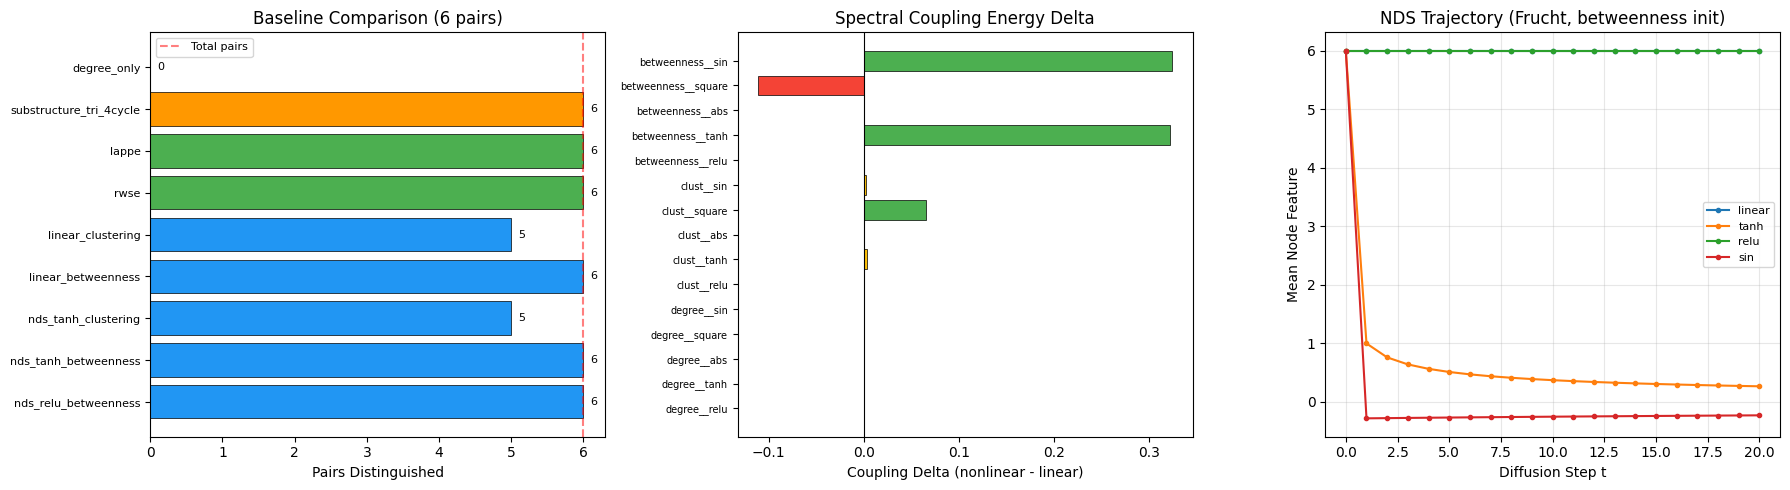

Saved nds_results.png


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Baseline Comparison ---
ax1 = axes[0]
method_names = list(timing_results.keys())
dist_counts = [timing_results[m]["pairs_distinguished_total"] for m in method_names]
total_pairs = timing_results[method_names[0]]["total_pairs"]
colors = ['#2196F3' if 'nds' in m or 'linear' in m else '#4CAF50' if m in ['rwse_k20', 'lappe_k20'] else '#FF9800'
          for m in method_names]
short_names = [m.replace('_T10', '').replace('_k20', '') for m in method_names]
bars = ax1.barh(range(len(method_names)), dist_counts, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_yticks(range(len(method_names)))
ax1.set_yticklabels(short_names, fontsize=8)
ax1.set_xlabel("Pairs Distinguished")
ax1.set_title(f"Baseline Comparison ({total_pairs} pairs)")
ax1.axvline(x=total_pairs, color='red', linestyle='--', alpha=0.5, label='Total pairs')
for i, v in enumerate(dist_counts):
    ax1.text(v + 0.1, i, str(v), va='center', fontsize=8)
ax1.legend(fontsize=8)

# --- Plot 2: Coupling Delta ---
ax2 = axes[1]
coupling_keys = list(coupling_summary.keys())
coupling_deltas = [coupling_summary[k]["coupling_delta"] for k in coupling_keys]
short_coupling = [k.replace('_vs_linear', '').replace('clustering_coeff', 'clust') for k in coupling_keys]
bar_colors = ['#F44336' if d < 0 else '#4CAF50' if d > 0.01 else '#FFC107' for d in coupling_deltas]
ax2.barh(range(len(coupling_keys)), coupling_deltas, color=bar_colors, edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(len(coupling_keys)))
ax2.set_yticklabels(short_coupling, fontsize=7)
ax2.set_xlabel("Coupling Delta (nonlinear - linear)")
ax2.set_title("Spectral Coupling Energy Delta")
ax2.axvline(x=0, color='black', linewidth=0.8)

# --- Plot 3: NDS Trajectory Example ---
ax3 = axes[2]
# Use Frucht graph with betweenness init
frucht_pair = graphs_by_pair.get("synth_frucht_vs_tietze")
if frucht_pair:
    g_frucht = frucht_pair[0]
    feat_frucht = compute_betweenness_centrality(g_frucht)
    for nonlin in ["linear", "tanh", "relu", "sin"]:
        traj = compute_nds(A_norm=g_frucht["A_norm"], init_features=feat_frucht, nonlinearity=nonlin, T=max(T_VALUES))
        # Plot mean feature value across nodes over time
        mean_traj = np.mean(traj, axis=0)
        ax3.plot(range(len(mean_traj)), mean_traj, marker='o', markersize=3, label=nonlin, linewidth=1.5)
    ax3.set_xlabel("Diffusion Step t")
    ax3.set_ylabel("Mean Node Feature")
    ax3.set_title("NDS Trajectory (Frucht, betweenness init)")
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("nds_results.png", dpi=100, bbox_inches="tight")
plt.show()
print("Saved nds_results.png")